# Bechdel Test for the movies' scripts

The Bechdel test requires that at least two women who talk to each other should talk about something else other than a man. The requirements are:
1. We have at least two women in the play
2. They must talk to each other
3. The discussion must be about something else other than a man

## Requirement

Using this data, find some statistics that you think would be relevant to the Bechdel test, visualise, and analyse them. (Bonus) if you have time, you can write a script to scrape more scripts from the website and run your analysis on a larger dataset.

What important statistics?
1. How many female characters there are?
2. How many conversation are there between female characters?
3. How many of those are about a man?


In [1]:
def prune_names(b):
    b = b.strip()
    if len(b.split()) > 2:
        return
    if not b.isupper():
        return
    for word in b.split():
        if not word.isalpha():
            return
    return b.strip().split()

In [2]:
def is_female(full_name):
    for character in female_characters:
            if character in full_name:
                return True
    return False

In [3]:
def speaking_about_male(text):
    for male in male_characters:
        if male in text.upper():
            return True
    return False

In [4]:
def disc_length(text):
    return len(text.split())

In [5]:
from bs4 import BeautifulSoup

f = open("data/8MM.html", "r")
html_doc = f.read()

soup = BeautifulSoup(html_doc, 'html.parser')

In [6]:
print(set([tag.name for tag in soup.find_all()])) #print all tags

{'u', 'b', 'pre'}


The `b` tag is reserved for stage indications and character names. So we will use this tag to scrape the name of the characters. I'm making an assumption that characters will (most likely) have just one name, possibly 2. So any `b` tag with more than 3 elements will be removed.

In [7]:
set_of_bs = set([tag.string for tag in soup.find_all('b')]) # get all b tags
bs = list(set_of_bs)

In [8]:
characters_names = []
for b in bs:
    if prune_names(b): characters_names.append(' '.join(prune_names(b)))
characters_names[0:5]

['DINO', 'WELLES', 'ABOVE', 'MRS CHRISTIAN', 'MANAGER']

## English names

Now that I've preprocessed the data a bit, the next step is to cross-reference the names with a list of all the English female names AND add prepositions such as: MRS, MS, DOCTOR etc (and the male names for later use).

The list of names is taken from [The USA Name Census](https://namecensus.com/first-names/common-female-first-names/)

In [9]:
import requests

url = 'https://namecensus.com/first-names/common-female-first-names/'

female_names = []

req = requests.get(url)

soup = BeautifulSoup(req.content, 'html.parser')
table = soup.find('table', attrs={'class':'table is-narrow is-bordered is-fullwidth mb-3'})
table_body = table.find('tbody')
rows = table_body.find_all('tr')

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    female_names.append(cols[1])

# extend and add the titles
female_names.extend(['MISS ', 'MRS. ', 'MS. ', 'MA\'AM ', 'WOMAN'])
female_names.sort()
female_names[0:5]

['ABBY', 'ABIGAIL', 'ADA', 'ADDIE', 'ADELA']

In [10]:
url = 'https://namecensus.com/first-names/common-male-first-names/'

male_names = []

req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')
table = soup.find('table', attrs={'class':'table is-narrow is-bordered is-fullwidth mb-3'})
table_body = table.find('tbody')
rows = table_body.find_all('tr')

for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    male_names.append(cols[1])

# extend and add the titles
male_names.extend(['MR ', 'MISTER '])
male_names.sort()
male_names[0:5]

['AARON', 'ADAM', 'ADRIAN', 'ALAN', 'ALBERT']

Now we have the most common names and their associated genders. We can now cross compare these lists with the list of possible characters to get the list of all characters.

In [11]:
female_characters = [] #list of all female characters
for female in female_names:
    for character_name in characters_names:
        if female in character_name: 
            female_characters.append(character_name)

male_characters = [] #list of all male characters
for male in male_names:
    for character_name in characters_names:
        if male in character_name and male not in female_names:
            male_characters.append(character_name)

female_characters = list(set(female_characters)) #remove duplicates
male_characters = list(set(male_characters)) #remove duplicates

female_characters, male_characters

(['EDDIE', 'LONGDALE', 'OLDER WOMAN', 'MRS CHRISTIAN', 'MANAGER', 'AMY'],
 ['POLITICIAN', 'MRS MATHEWS', 'MRS CHRISTIAN', 'MAX'])

As you can see, there are some edge cases: LONGDALE appears in both genders, MRS CHRISTIAN is in both, because CHRISTIAN is a male name. Unfortunately, for a quick and dirty version, this will have to do.

In [12]:
import pandas as pd

df = pd.DataFrame(columns=['female_speaking','text', 'female_speaking_to_female', 'speaking_about_male'])

f = open("data/8MM.html", "r") #have to init. BeautifulSoup again
html_doc = f.read()
soup = BeautifulSoup(html_doc, 'html.parser')

for x in soup.find_all('b'):
    if prune_names(x.text): 
        df = df.append({
            'female_speaking':' '.join(prune_names(x.text)), 
            'text':x.next_sibling, 
            'female_speaking_to_female': False, 
            'speaking_about_male': False}, 
            ignore_index=True)

/var/folders/lk/7_gr5q5s4030tx9c5c276vqr0000gn/T/ipykernel_90820/38513310.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/lk/7_gr5q5s4030tx9c5c276vqr0000gn/T/ipykernel_90820/38513310.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/lk/7_gr5q5s4030tx9c5c276vqr0000gn/T/ipykernel_90820/38513310.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/lk/7_gr5q5s4030tx9c5c276vqr0000gn/T/ipykernel_90820/38513310.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/lk/7_gr5q5s4030tx9c5c276vqr0000gn/T/ipykernel_90820/385

In [13]:
df.head(10)

,female_speaking,text,female_speaking_to_female,speaking_about_male
0,CAB DRIVER,Where to?\n\n Welles keeps ...,False,False
1,WELLES,Follow that limousine. Don't g...,False,False
2,CAB DRIVER,You kidding?\n\n,False,False
3,WELLES,Nope.\n\n The cab set in mo...,False,False
4,CAB DRIVER,"Uh, listen... you're not suppos...",False,False
5,WELLES,How about this... every cigaret...,False,False
6,CAB DRIVER,"Okay... okay, yeah, that'd be g...",False,False
7,OLDER WOMAN,Thank you. \n\n Welles no...,False,False
8,AMY,Welcome home.\n\n,False,False
9,WELLES,Do you know how much I missed...,False,False


We've created a DataFrame that will be the base assumption for our inferences. The first column will contain only the female speakers and the other ones are self explanatory.

For this goal, I'm going to remove characters that don't have a name, such as CAB DRIVER or POLITICIAN. In order to assess their gender, an in depth analysis of the text itself is required (we cannot assume the CAB DRIVER is male or the POLITIAN is female). Thus, for the sake of simplicity I will simply remove the rows with such characters.

In [14]:
df = df[df['female_speaking'].apply(is_female)] # leave only female
df.head()

,female_speaking,text,female_speaking_to_female,speaking_about_male
7,OLDER WOMAN,Thank you. \n\n Welles no...,False,False
8,AMY,Welcome home.\n\n,False,False
10,AMY,What's this... have you been\...,False,False
12,AMY,Your clothing reeks of it. \n\n,False,False
14,AMY,I'm not accusing you... \n\n,False,False


## Checking where a woman is speaking to another woman

In [15]:
for i in range(len(df)-1):
    if is_female(df.iloc[i+1, 0]): #check if there is a woman is speaking to another woman
        df.iloc[i,2] = True

## Checking where the discussion is about a male

In [16]:
df['speaking_about_male'] = df['text'].apply(speaking_about_male) #check if they're speaking about males

In [17]:
# remove dialogues where there aren't two females talking OR they're talking about a male
df = df[df['female_speaking_to_female'] & df['speaking_about_male'] == False]

In [18]:
#length of each dialogue
df['disc_length'] = df['text'].apply(disc_length)

# Simple statistics

After all that work, we can see the final results and the statistics associated with them. I have also added some complementary relationship graphs to show all the relationships between the female characters.

In [19]:
nr_female_chars = len(female_characters)
female_to_female_discs = len(df)-1
average_disc_length = df['disc_length'].mean()
print('Nr of female characters: ', nr_female_chars)
print('Nr of female to female discussions: ', female_to_female_discs)
print('The average number of words in each discussion: ', average_disc_length)

Nr of female characters:  6
Nr of female to female discussions:  161
The average number of words in each discussion:  17.685185185185187


In [20]:
relationships = []

for i in range(len(df)-1):
    relationships.append({"source": df.iloc[i, 0], "target": df.iloc[i+1, 0]})
relationship_df = pd.DataFrame(relationships)

In [21]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [22]:
import networkx as nx

# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

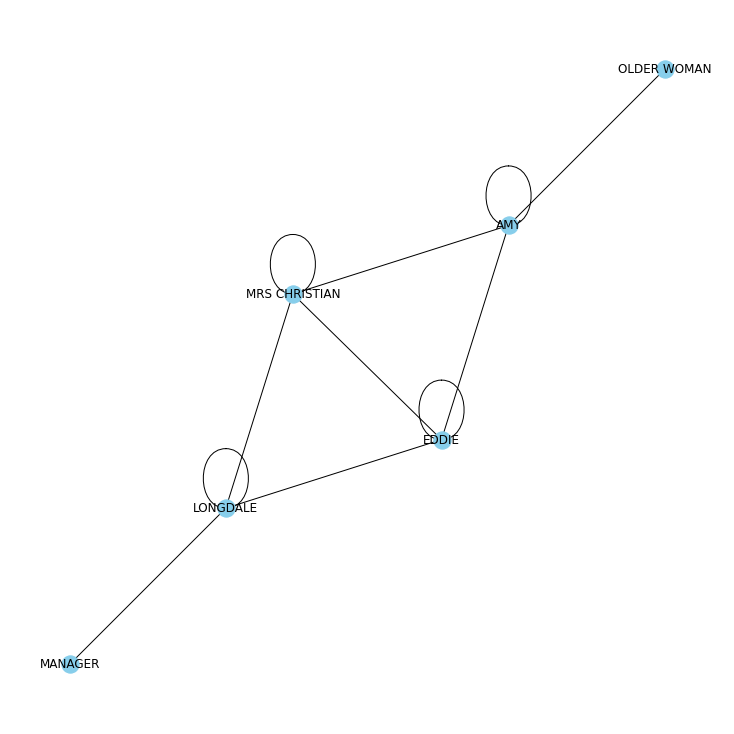

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [24]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("book.html")

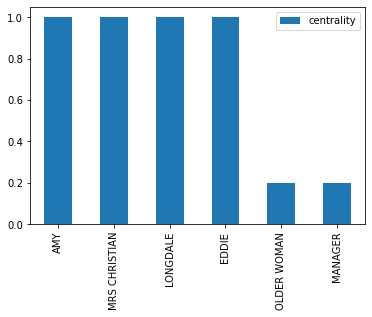

In [25]:
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar");

From these graphs we can see the relationship between all the characters and their associated importance to each other. 

From the `centrality` graph we can see how central the characters are to each other.